In [29]:
pip install dcor

Note: you may need to restart the kernel to use updated packages.


In [30]:
pip install tigramite

Note: you may need to restart the kernel to use updated packages.


In [31]:
! mamba install -y pynco pynio pyngl


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.1.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['pynco', 'pynio', 'pyngl']

[+] 0.0s
conda-forge/linux-64 ━━╸━━━━━━━━━━━━━━━╸━━━━   0.0 B /  ??.?MB

In [32]:
import gcsfs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cftime
from nco import Nco
from tqdm import tqdm
import Ngl #plotting science data
import xesmf as xe

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn

from utils.constants import TAU_MIN, TAU_MAX
import utils.links as links
import utils.helpers as helpers

In [33]:
optional_ozone = 'pbuf_ozone'
predictor_names = ['pbuf_SOLIN', 'pbuf_LHFLX', 'pbuf_SHFLX', 'state_ps', 'state_q0001', 'state_t']
predictand_names = ['cam_out_PRECC']
ds = helpers.load_vars_xarray(predictor_names, predictand_names).isel(lev=30, ncol=0)
ds

<xarray.Dataset>
Dimensions:            (time: 2920)
Coordinates:
  * time               (time) object 0001-02-01 12:00:00 ... 0009-01-31 12:00:00
    ncol               int64 0
Data variables:
    pbuf_SOLIN         (time) float64 ...
    pbuf_LHFLX         (time) float64 ...
    pbuf_SHFLX         (time) float64 ...
    state_ps           (time) float64 ...
    state_q0001        (time) float64 ...
    state_t            (time) float64 ...
    out_cam_out_PRECC  (time) float64 ...
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [34]:
fs = gcsfs.GCSFileSystem()
# fs.ls("gs://leap-persistent-ro/sungdukyu")

# mapper_in = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr')
# mapper_out = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
mapper_grid = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr')

# ds_train_in = xr.open_dataset(mapper_in, engine='zarr')
# ds_train_out = xr.open_dataset(mapper_out, engine='zarr')
gridpoints = xr.open_dataset(mapper_grid, engine ='zarr')

## Reformat the Data in Time of Day

In [35]:
# # see above: **ymd** includes date information: the first digit indicates the index of year, the next two digits indicate the month and the last three digits indicates the calendar day in the year.
# year=ds_train_in['ymd']//10000 # gets first digit
# month=ds_train_in['ymd']%10000//100 # gets 4 right digits then gets the 2 left digits
# day=ds_train_in['ymd']%10000%100 # gets 4 right digits then gets the 2 right digits
# hour=ds_train_in['tod']//3600 # seconds per minute, minutes per hour
# minute=ds_train_in['tod']%3600//60 # removes hours, leaves number of seconds in the day, then divide by 60 to get minutes

# t = []
# for k in range(len(ds_train_in['ymd'])): # go through ds
#     t.append(cftime.DatetimeNoLeap(year[k],month[k],day[k],hour[k],minute[k]))
# ds_train_in['sample'] = t # Add the time array to the 'sample' dimension and rename
# ds_train_in = ds_train_in.rename({'sample':'time'})
# ds_train_in = ds_train_in.drop(['tod','ymd'])

# ds_train_in.time.values[0:5] # Check the current **time** dimension, read the timestep

In [36]:
# # see above: **ymd** includes date information: the first digit indicates the index of year, the next two digits indicate the month and the last three digits indicates the calendar day in the year.
# year=ds_train_out['ymd']//10000 # gets first digit
# month=ds_train_out['ymd']%10000//100 # gets 4 right digits then gets the 2 left digits
# day=ds_train_out['ymd']%10000%100 # gets 4 right digits then gets the 2 right digits
# hour=ds_train_out['tod']//3600 # seconds per minute, minutes per hour
# minute=ds_train_out['tod']%3600//60 # removes hours, leaves number of seconds in the day, then divide by 60 to get minutes

# t = []
# for k in range(len(ds_train_out['ymd'])): # go through ds
#     t.append(cftime.DatetimeNoLeap(year[k],month[k],day[k],hour[k],minute[k]))
# ds_train_out['sample'] = t # Add the time array to the 'sample' dimension and rename
# ds_train_out =ds_train_out.rename({'sample':'time'})
# ds_train_out = ds_train_out.drop(['tod','ymd'])

# ds_train_out.time.values[0:5] # Check the current **time** dimension, read the timestep

In [37]:
# ds_train_in.time.values[0:5]

In [38]:
# optional_ozone = 'pbuf_ozone'
# predictor_names = ['pbuf_SOLIN', 'pbuf_LHFLX', 'pbuf_SHFLX', 'state_ps', 'state_q0001', 'state_t']
# predictand_names = ['cam_out_PRECC']

# ds_predictors = ds_train_in.isel(lev=30, ncol=0)[predictor_names]
# ds_predictands = ds_train_out.isel(lev=30, ncol=0)[predictand_names]
# ds_predictors


In [39]:
# # Suppose 'da1' and 'da2' are your xarray DataArrays
# combined = xr.merge([ds_predictors, ds_predictands])

In [40]:
da = ds.to_array(dim='variable') # = spcam_data
parents = {0, 1, 2, 3, 4, 5}
children = {6}

In [59]:
da[6] #['pbuf_SOLIN', 'pbuf_LHFLX', 'pbuf_SHFLX', 'state_ps', 'state_q0001', 'state_t']

<xarray.DataArray (time: 2920)>
array([0.00000000e+00, 0.00000000e+00, 1.58517362e-09, ...,
       9.29512891e-09, 6.30778638e-14, 0.00000000e+00])
Coordinates:
  * time      (time) object 0001-02-01 12:00:00 ... 0009-01-31 12:00:00
    ncol      int64 0
    variable  <U17 'out_cam_out_PRECC'
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [ ]:
def find_links(spcam_data, var_names, list_var_data, list_pc_alpha, cond_ind_test, verbosity=0):
    # spcam_data is same as my da
    # The order of the names in var_names corresponds to the order of the columns in spcam_data.
    # parents = indices
    # children = indices
    selected_links = links.select_links(TAU_MIN, TAU_MAX, parents, children)

    # Initialize dataframe object, specify time axis and variable names
    dataframe = pp.DataFrame(
        spcam_data, datatime=np.arange(len(spcam_data)), var_names=var_names
    )

    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test, verbosity=verbosity)

    return run_pc_stable(pcmci, selected_links, list_pc_alpha)


In [43]:
var_names = predictor_names.extend(predictand_names)
dataframe = pp.DataFrame(da.T.values,
                         datatime=da.time.values,
                         var_names=var_names)

ParCorr = parcorr.ParCorr(significance='analytic')
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr, verbosity=1)

In [51]:
pcmci.verbosity = 1
tau_max=2
results = pcmci.run_pc_stable(tau_max=tau_max, pc_alpha=.59)
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')

tp.plot_graph(graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=20,
    label_fontsize=20,
    tick_label_size=14,
    node_label_size=20,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.5
    )


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.59]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable 0 has 11 link(s):
        (0 -1): max_pval = 0.00000, min_val =  1.000
        (0 -2): max_pval = 0.00000, min_val =  0.999
        (5 -2): max_pval = 0.00125, min_val = -0.060
        (1 -2): max_pval = 0.00720, min_val = -0.050
        (6 -1): max_pval = 0.00925, min_val = -0.048
        (1 -1): max_pval = 0.03379, min_val = -0.039
        (6 -2): max_pval = 0.04420, min_val = -0.037
        (3 -2): max_pval = 0.08341, min_val = -0.032
        (5 -1): max_pval = 0.30893, min_val = -0.019
        (4 -2): max_pval = 0.31389, min_val =  0.019
        (2 -2): max_pval = 0.48419, min_val = -0.013

    Variable 1 has 10 link(s):
        (2 -1): max_pval = 0.00000, min_val =  0.219
        (1 -1): max_pval = 0.00000, min_val =  0.199
        (2 -2): max_pva

KeyError: 'p_matrix'


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable 0 has 11 link(s):
    [pc_alpha = 0.5]
        (0 -1): max_pval = 0.00000, min_val =  1.000
        (0 -2): max_pval = 0.00000, min_val =  0.999
        (5 -2): max_pval = 0.00125, min_val = -0.060
        (1 -2): max_pval = 0.00720, min_val = -0.050
        (6 -1): max_pval = 0.00925, min_val = -0.048
        (1 -1): max_pval = 0.03379, min_val = -0.039
        (6 -2): max_pval = 0.04420, min_val = -0.037
        (3 -2): max_pval = 0.08341, min_val = -0.032
        (5 -1): max_pval = 0.30893, min_val = -0.019
        (4 -2): max_pval = 0.31389, min_val =  0.019
        (2 -2): max_pval = 0.48419, min_val = -0.013

    Variable 1 has 9 link(s):
    [pc_alpha = 0.5]
        (2 -1): max_pval = 0.00000, min_val =  0.219
        (1

(<Figure size 640x480 with 1 Axes>, <Axes: >)

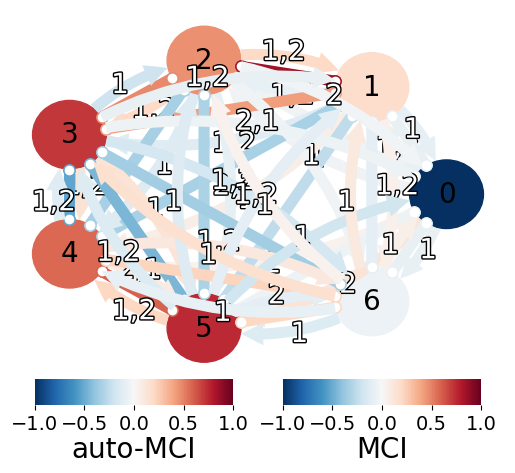

In [52]:
pcmci.verbosity = 1
tau_max=2
results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=None)
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')

tp.plot_graph(graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=20,
    label_fontsize=20,
    tick_label_size=14,
    node_label_size=20,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.5
    )

(<Figure size 400x400 with 1 Axes>, <Axes: >)

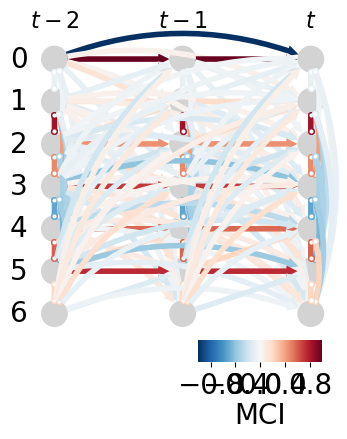

In [45]:
tp.plot_time_series_graph(
    figsize=(4, 4),
    val_matrix=results['val_matrix'],
    graph = results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    label_fontsize=20,
    tick_label_size=20
)

In [46]:
def run_pc_stable(pcmci, selected_links, list_pc_alpha):
    pc_alpha_results = dict()
    for pc_alpha in list_pc_alpha:
        try:
            links = pcmci.run_pc_stable(
                tau_min=TAU_MIN,
                tau_max=TAU_MAX,
                selected_links=selected_links,
                pc_alpha=pc_alpha,
            )
            # "result_parents" will now be a dictionary with only the
            # causal parents for each variable like selected_links, but
            # only with the actual links

            # link_matrix = pcmci.return_significant_links(
            #     pq_matrix=pcmci.p_matrix,
            #     val_matrix=pcmci.val_matrix,
            #     alpha_level=pc_alpha
            # )['link_matrix']

            results = {
                "links": links,
                "p_matrix": pcmci.p_matrix,
                "val_matrix": pcmci.val_matrix,
                # "link_matrix" : link_matrix,
                "var_names": pcmci.var_names,
            }
        except ValueError as e:
            print(e)
            results = {}
        pc_alpha_results[str(pc_alpha)] = results

    return pc_alpha_results

In [47]:
def single(
    gridpoints, #grid info
    var_parents,
    var_children,
    cond_ind_test,
    ind_test_name,
    pc_alphas,
    shifting,
    levels,
    parents_idx_levs,
    children_idx_levs,
    idx_lats,
    idx_lons,
    data_folder,
    experiment,
    output_file_pattern,
    output_folder,
    overwrite,
    verbosity,
):

    ## Processing
    len_grid = len(gridpoints)
    t_start = time.time()
    for i_grid, (lat, lon) in enumerate(gridpoints):  

        t_start_gridpoint = time.time()
        data_parents = None

        idx_lat = idx_lats[i_grid]
        idx_lon = idx_lons[i_grid]

        for child in var_children:
            print(f"{dt.now()} Variable: {child.name}")
            if child.dimensions == 2:
                child_levels = [[levels[-1], 0]]
            elif child.dimensions == 3:
                child_levels = children_idx_levs

            for level in child_levels:
                results_file = utils.generate_results_filename_single(
                    child,
                    level[-1],
                    lat,
                    lon,
                    ind_test_name,
                    experiment,
                    output_file_pattern,
                    output_folder,
                )

                if not overwrite and results_file.is_file():
                    print(f"{dt.now()} Found file {results_file}, skipping.")
                    continue  # Ignore this level

                # Only load parents if necessary to analyze a child
                # they stay loaded until the next gridpoint
                if data_parents is None:

                    print(
                        f"{dt.now()} Gridpoint {i_grid+1}/{len_grid}:"
                        f" lat={lat} ({idx_lat}), lon={lon} ({idx_lon})"
                    )

                    print(f"Load Parents (state fields)...")
                    t_before_load_parents = time.time()
                    data_parents = utils.load_data(
                        var_parents,
                        0, # shifting always 0 (no-shifting)
                        experiment,
                        data_folder,
                        parents_idx_levs,
                        idx_lat,
                        idx_lon,
                    )
                    time_load_parents = datetime.timedelta(
                        seconds=time.time() - t_before_load_parents
                    )
                    print(f"{dt.now()} All parents loaded. Time: {time_load_parents}")

                # Process child
                data_child = utils.load_data(
                    [child], shifting, experiment, data_folder, [level], idx_lat, idx_lon
                )
                data = [*data_parents, *data_child]

                # Find links
                print(
                    f"{dt.now()} "
                    f"Finding links for {child.name} at level {level[-1]+1}"
                )
                t_before_find_links = time.time()
                if ind_test_name == 'parcorr':
                    results = find_links(data, pc_alphas, cond_ind_test, verbosity)
                elif ind_test_name == 'pearsonr':
                    results = pearsonr(data, pc_alphas, cond_ind_test, verbosity)
                else:
                    print(f"Invalid independence_test: {setup.independence_test}; stop!")
                    sys.exit()
                time_links = datetime.timedelta(
                    seconds=time.time() - t_before_find_links
                )
                total_time = datetime.timedelta(seconds=time.time() - t_start)
                print(
                    f"{dt.now()} Links found. Time: {time_links}"
                    f" Total time so far: {total_time}"
                )

                # Store causal links
                utils.save_results(results, results_file)

        time_point = datetime.timedelta(seconds=time.time() - t_start_gridpoint)
        total_time = datetime.timedelta(seconds=time.time() - t_start)
        print(
            f"{dt.now()} All links in gridpoint found. Time: {time_point}."
            f" Total time so far: {total_time}"
        )
        print()

    print(f"{dt.now()} Execution complete. Total time: {total_time}")

In [48]:
list_pc_alpha = np.arange(0, 1.1, 0.1)

res = run_pc_stable(pcmci, None, list_pc_alpha)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 1
pc_alpha = [0.0]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable 0 has 1 link(s):
        (0 -1): max_pval = 0.00000, min_val =  1.000

    Variable 1 has 0 link(s):

    Variable 2 has 1 link(s):
        (2 -1): max_pval = 0.00000, min_val =  0.651

    Variable 3 has 1 link(s):
        (3 -1): max_pval = 0.00000, min_val =  0.854

    Variable 4 has 0 link(s):

    Variable 5 has 1 link(s):
        (5 -1): max_pval = 0.00000, min_val =  0.925

    Variable 6 has 0 link(s):

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 1
pc_alpha = [0.1]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable 0 has 6 link(s):
        (0 -1): max_pval = 0.00000, min_val =  1.000
        (5 -1): max_pval = 0.00000, min_v

In [49]:
res

{'0.0': {'links': {0: [(0, -1)],
   1: [],
   2: [(2, -1)],
   3: [(3, -1)],
   4: [],
   5: [(5, -1)],
   6: []},
  'p_matrix': array([[[1.00000000e+000, 0.00000000e+000],
          [1.00000000e+000, 1.77229006e-021],
          [1.00000000e+000, 1.32565385e-041],
          [1.00000000e+000, 2.30380505e-300],
          [1.00000000e+000, 9.01566890e-121],
          [1.00000000e+000, 1.55275590e-025],
          [1.00000000e+000, 1.26024589e-010]],
  
         [[1.00000000e+000, 4.39683892e-023],
          [1.00000000e+000, 1.58130194e-027],
          [1.00000000e+000, 3.24342720e-192],
          [1.00000000e+000, 2.66175656e-076],
          [1.00000000e+000, 1.35986601e-105],
          [1.00000000e+000, 3.94127992e-037],
          [1.00000000e+000, 8.35436837e-018]],
  
         [[1.00000000e+000, 8.98882466e-042],
          [1.00000000e+000, 4.81963013e-042],
          [1.00000000e+000, 0.00000000e+000],
          [1.00000000e+000, 1.31018534e-158],
          [1.00000000e+000, 8.8729227